<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week7%20/BiDirectionalRNN/ReviewTokoBaju.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

<ipython-input-4-89d98b70a433>:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [5]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
# 1. Data Loading and Exploration
print("Loading data...")
df = pd.read_csv('https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv')
print(f"Dataset shape: {df.shape}")
print("\nSample data:")
print(df.head())

Loading data...
Dataset shape: (23486, 11)

Sample data:
   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                      

In [7]:
# 2. Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64


In [9]:
# 3. Data Preprocessing
print("\nPreprocessing data...")

# Create target variable - assuming Recommended IND is our target for sentiment
df['target'] = df['Recommended IND'].astype(int)


Preprocessing data...


In [10]:
# Check class distribution
print("\nClass distribution:")
print(df['target'].value_counts())



Class distribution:
target
1    19314
0     4172
Name: count, dtype: int64


In [11]:
# 4. Text Preprocessing and Tokenization
def preprocess_text(text):
    if isinstance(text, str):
        return text.lower()
    return ""

df['processed_text'] = df['Review Text'].apply(preprocess_text)

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'],
    df['target'],
    test_size=0.2,
    random_state=42,
    stratify=df['target']
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 18788
Testing set size: 4698


In [13]:
# Tokenize the text
max_words = 10000  # Maximum number of words to keep
max_len = 100  # Maximum length of reviews

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [14]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [15]:
# 5. Basic BiRNN Model
def build_model(hp=None):
    embedding_dim = 128 if hp is None else hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
    lstm_units = 64 if hp is None else hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dropout_rate = 0.5 if hp is None else hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    learning_rate = 0.001 if hp is None else hp.Choice('learning_rate', values=[1e-2, 1e-3, 5e-4, 1e-4])

    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Bidirectional(LSTM(lstm_units)),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [17]:
# 6. Train the basic model
print("\nTraining basic BiRNN model...")
model = build_model()
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy')

history = model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)



Training basic BiRNN model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8171 - loss: 0.4528

235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8173 - loss: 0.4521 - val_accuracy: 0.8856 - val_loss: 0.2624
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9030 - loss: 0.2462

235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9030 - loss: 0.2461 - val_accuracy: 0.8898 - val_loss: 0.2783
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9298 - loss: 0.1939 - val_accuracy: 0.8898 - val_loss: 0.3099
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9400 - loss: 0.1669 - val_accuracy: 0.8800 - val_loss: 0.3350


In [20]:
# 7. Model Evaluation
print("\nEvaluating the model...")
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")


Evaluating the model...
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Accuracy: 0.8782
Precision: 0.9289
Recall: 0.9226
F1 Score: 0.9257
AUC-ROC: 0.9145


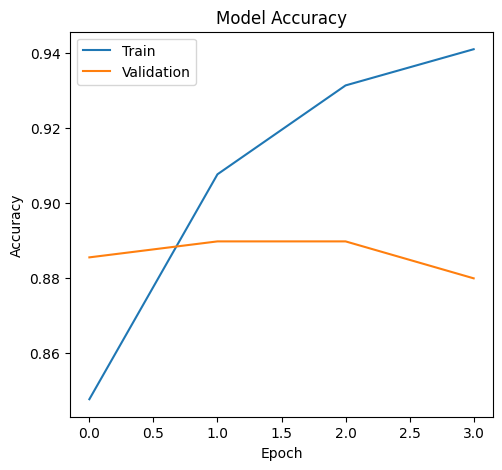

In [21]:
# 8. Visualizations
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

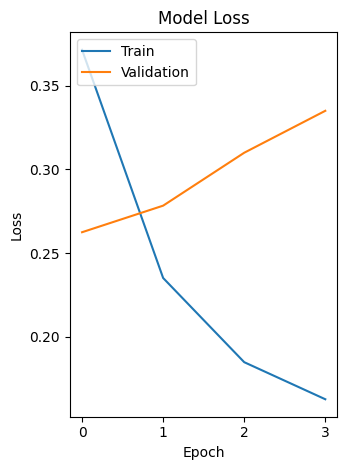

In [22]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

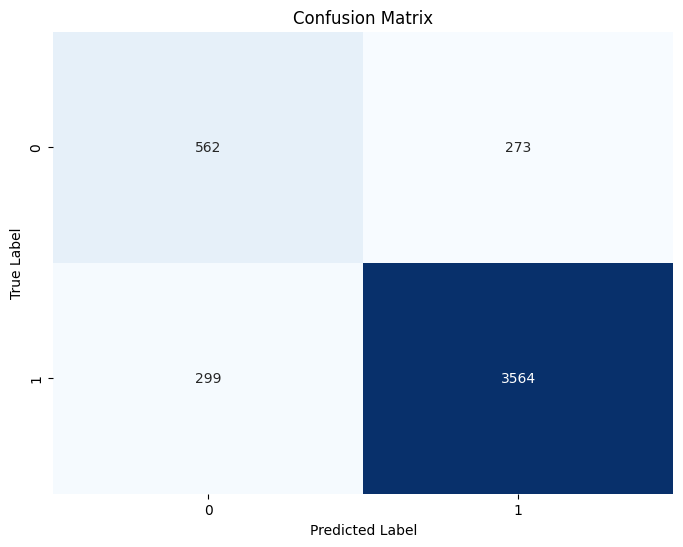

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

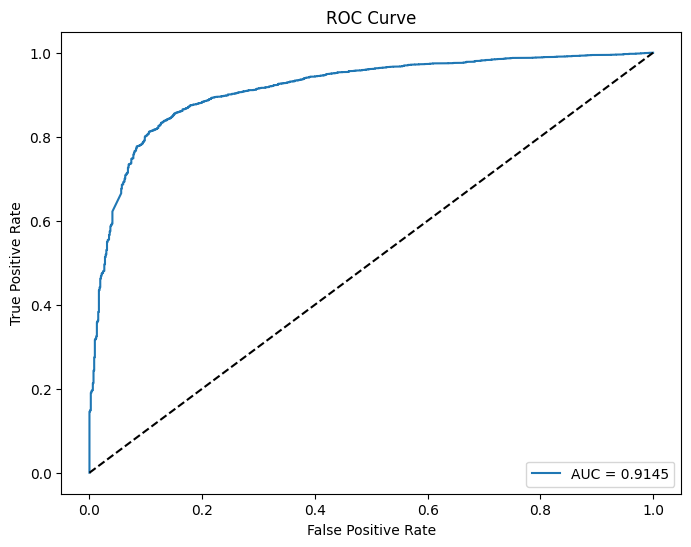

In [24]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()


In [25]:
# 9. Hyperparameter Tuning
print("\nStarting hyperparameter tuning...")

def model_builder(hp):
    return build_model(hp)

tuner = RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='clothing_reviews'
)

tuner.search(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Trial 5 Complete [00h 00m 57s]
val_accuracy: 0.893028199672699

Best val_accuracy So Far: 0.8959553241729736
Total elapsed time: 00h 04m 21s


In [26]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\nBest hyperparameters found:")
print(f"Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")



Best hyperparameters found:
Embedding Dimension: 192
LSTM Units: 128
Dropout Rate: 0.4
Learning Rate: 0.0005


In [27]:
# 10. Train the model with best hyperparameters
print("\nTraining final model with best hyperparameters...")
best_model = tuner.hypermodel.build(best_hps)

final_history = best_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)


Training final model with best hyperparameters...
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.8171 - loss: 0.4603 - val_accuracy: 0.8874 - val_loss: 0.2841
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8951 - loss: 0.2576

235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8951 - loss: 0.2576 - val_accuracy: 0.8914 - val_loss: 0.2589
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9215 - loss: 0.2018 - val_accuracy: 0.8912 - val_loss: 0.2867
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9404 - loss: 0.1664 - val_accuracy: 0.8765 - val_loss: 0.3134
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9532 - loss: 0.1392 - val_accuracy: 0.8872 - val_loss: 0.3110


In [29]:
# 11. Final Evaluation
print("\nFinal evaluation...")
y_pred_prob_final = best_model.predict(X_test_pad)
y_pred_final = (y_pred_prob_final > 0.5).astype(int)

# Calculate final evaluation metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_pred_prob_final)

print("\nFinal Model Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"AUC-ROC: {final_auc:.4f}")



Final evaluation...
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Final Model Performance:
Accuracy: 0.8836
Precision: 0.9133
Recall: 0.9485
F1 Score: 0.9305
AUC-ROC: 0.9195


In [30]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.58      0.64       835
           1       0.91      0.95      0.93      3863

    accuracy                           0.88      4698
   macro avg       0.81      0.77      0.79      4698
weighted avg       0.88      0.88      0.88      4698



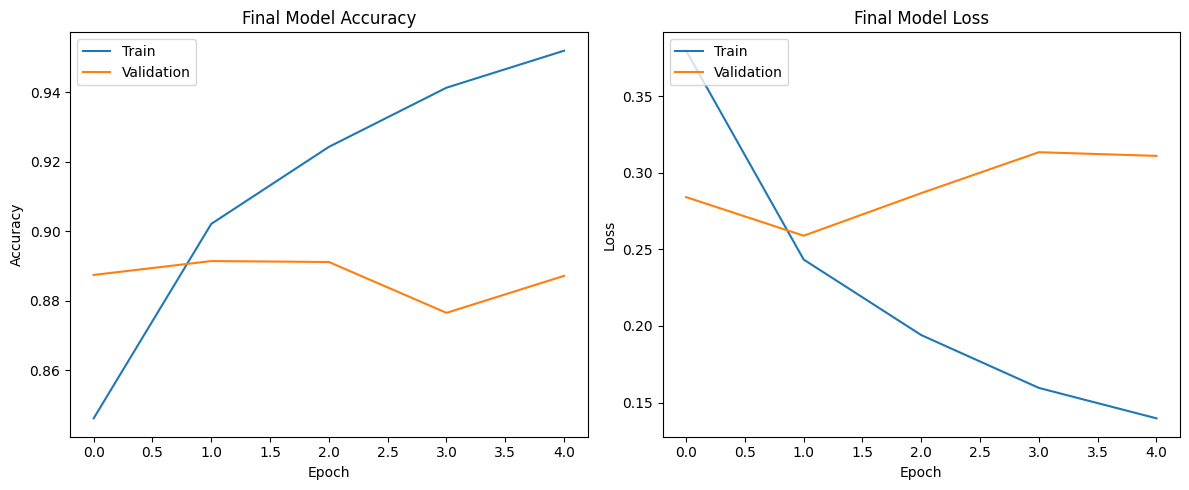

In [31]:
# 12. Final Visualizations for the best model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'])
plt.plot(final_history.history['val_accuracy'])
plt.title('Final Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'])
plt.plot(final_history.history['val_loss'])
plt.title('Final Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('final_training_metrics.png')
plt.show()

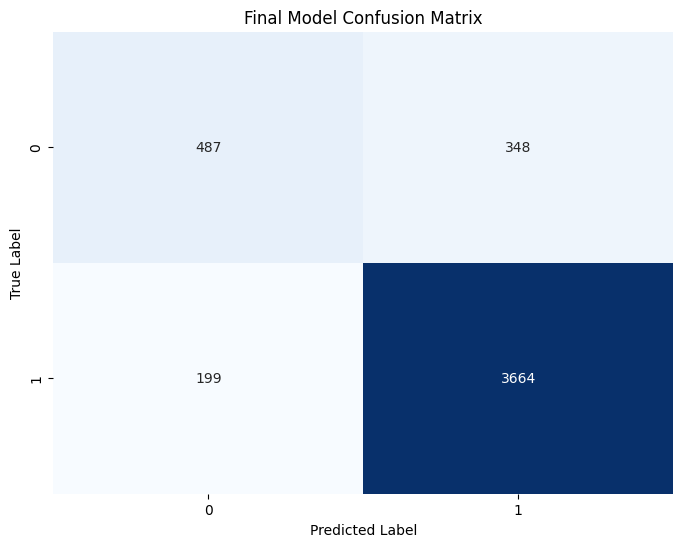

In [32]:
# Final Confusion Matrix
final_cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Final Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('final_confusion_matrix.png')
plt.show()

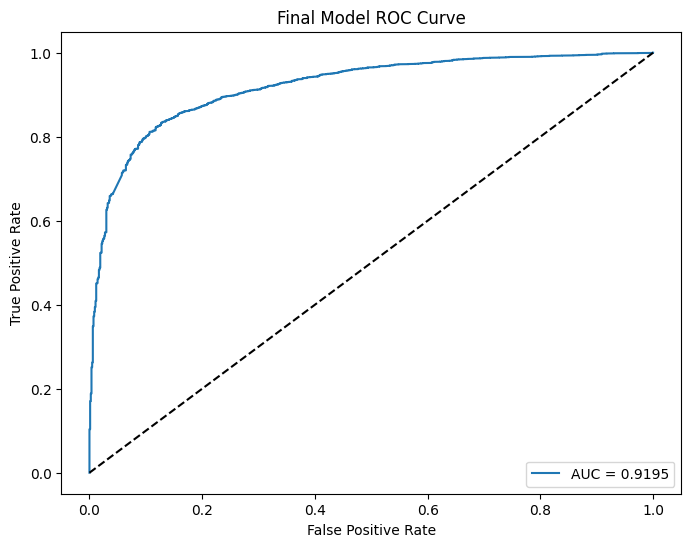

In [33]:
# Final ROC Curve
final_fpr, final_tpr, _ = roc_curve(y_test, y_pred_prob_final)
plt.figure(figsize=(8, 6))
plt.plot(final_fpr, final_tpr, label=f'AUC = {final_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Model ROC Curve')
plt.legend(loc='lower right')
plt.savefig('final_roc_curve.png')
plt.show()
